In [13]:
# Cell 0 — env + imports (idempotent)
import importlib, subprocess, sys, os, random, math, json, time
def ensure(mod, pip_name=None):
    try: importlib.import_module(mod)
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "--quiet", pip_name or mod])
        importlib.invalidate_caches()

for m,p in [
    ("numpy", None), ("matplotlib", None), ("tqdm", None),
    ("scikit-image", "scikit-image"), ("torch", None)
]:
    ensure(m,p)

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
from skimage.morphology import disk
from skimage.filters import rank as sk_rank

np.set_printoptions(suppress=True, precision=3)
random.seed(42); np.random.seed(42)
print("✅ ready:", "numpy", np.__version__)


✅ ready: numpy 1.24.1


In [14]:
# Cell 1 — paths (EDIT the two ‘_ROOT’ lines only)

# 1) KITTI training root that contains: velodyne, calib, label_2
KITTI_ROOT = Path(r"C:\Users\DELL\OpenPCDet\data\kitti\training")

# 2) Outputs root (we’ll keep runs numbered: run_1, run_2, …)
OUT_ROOT   = Path(r"D:\Data\essentials\Thapar\MTech\Projects\Main proj\bev_npu_outputs\new_outputs")

# -----------------------------------------------------------------------------
VELO_DIR = KITTI_ROOT / "velodyne"
CAL_DIR  = KITTI_ROOT / "calib"
LAB_DIR  = KITTI_ROOT / "label_2"

assert VELO_DIR.exists() and CAL_DIR.exists() and LAB_DIR.exists(), "❌ Check KITTI_ROOT subfolders (velodyne/calib/label_2)"

# Choose / create run folder
RUN_ID  = 1  # <- bump manually when you want a new run folder
RUN_DIR = OUT_ROOT / f"run_{RUN_ID}"
(RUN_DIR / "bev_u8").mkdir(parents=True, exist_ok=True)
(RUN_DIR / "bev_float").mkdir(parents=True, exist_ok=True)
(RUN_DIR / "masks").mkdir(parents=True, exist_ok=True)

# Frame IDs present in all three folders
ALL_IDS = sorted(set(p.stem for p in VELO_DIR.glob("*.bin"))
                 & set(p.stem for p in CAL_DIR.glob("*.txt"))
                 & set(p.stem for p in LAB_DIR.glob("*.txt")))
print(f"frames available: {len(ALL_IDS)} (e.g., {ALL_IDS[:5]})")
print("RUN_DIR =", RUN_DIR)


frames available: 7481 (e.g., ['000000', '000001', '000002', '000003', '000004'])
RUN_DIR = D:\Data\essentials\Thapar\MTech\Projects\Main proj\bev_npu_outputs\new_outputs\run_1


In [15]:
# Cell 2 — BEV config + functions

cfg = {
    "x_range": (0.0, 70.0),    # meters forward
    "y_range": (-40.0, 40.0),  # meters left/right
    "z_range": (-3.0, 2.0),    # meters up
    "H": 704, "W": 800,        # grid size
    "q": {"count_cap": 5.0, "zvar_cap": 1.0}
}

def load_points_bin(fbin: Path):
    return np.fromfile(fbin, dtype=np.float32).reshape(-1, 4)  # (x,y,z,i)

def bev_from_points(points: np.ndarray, cfg: dict) -> np.ndarray:
    x, y, z, i = points.T
    xr, yr, zr = cfg["x_range"], cfg["y_range"], cfg["z_range"]
    H, W = cfg["H"], cfg["W"]
    m = (x>=xr[0])&(x<=xr[1])&(y>=yr[0])&(y<=yr[1])&(z>=zr[0])&(z<=zr[1])
    x, y, z, i = x[m], y[m], z[m], i[m]
    row_scale = (H - 1) / (xr[1] - xr[0])
    col_scale = (W - 1) / (yr[1] - yr[0])
    iy = np.floor((x - xr[0]) * row_scale).astype(np.int32)
    ix = np.floor((y - yr[0]) * col_scale).astype(np.int32)
    lin = iy * W + ix
    count = np.bincount(lin, minlength=H*W).astype(np.float32).reshape(H, W)
    sum_z  = np.bincount(lin, weights=z,   minlength=H*W).reshape(H, W)
    sum_z2 = np.bincount(lin, weights=z*z, minlength=H*W).reshape(H, W)
    sum_i  = np.bincount(lin, weights=i,   minlength=H*W).reshape(H, W)
    zmax = np.full(H*W, -1e9, dtype=np.float32)
    np.maximum.at(zmax, lin, z); zmax = zmax.reshape(H, W)
    eps   = 1e-6
    zmean = sum_z / np.maximum(count, eps)
    imean = sum_i / np.maximum(count, eps)
    zvar  = (sum_z2 / np.maximum(count, eps)) - zmean**2
    zvar  = np.clip(zvar, 0.0, None)
    return np.stack([count, zmax, zmean, imean, zvar], axis=0)

def quantize_bev_u8(bev: np.ndarray, cfg: dict) -> np.ndarray:
    zr = cfg["z_range"]; q = cfg["q"]
    q0 = np.clip((bev[0] / q["count_cap"]) * 255.0, 0, 255).astype(np.uint8)
    z_to_u8 = lambda a: np.clip(((a - zr[0]) / (zr[1] - zr[0])) * 255.0, 0, 255).astype(np.uint8)
    q1 = z_to_u8(bev[1]); q2 = z_to_u8(bev[2])
    q3 = np.clip(bev[3] * 255.0, 0, 255).astype(np.uint8)
    q4 = np.clip((bev[4] / cfg["q"]["zvar_cap"]) * 255.0, 0, 255).astype(np.uint8)
    return np.stack([q0, q1, q2, q3, q4], axis=0)


In [16]:
# Cell 3 — calib/labels parsing + 3D→BEV footprint

def read_calib(fid: str):
    R0_rect = None; Tr_v2c = None
    with open(CAL_DIR / f"{fid}.txt") as f:
        for ln in f:
            ln = ln.strip()
            if not ln: continue
            k, v = ln.split(":", 1)
            arr = np.fromstring(v.strip(), sep=" ")
            if k == "R0_rect":      R0_rect = arr.reshape(3,3)
            elif k == "Tr_velo_to_cam": Tr_v2c = arr.reshape(3,4)
    assert R0_rect is not None and Tr_v2c is not None
    return R0_rect, Tr_v2c

def load_labels(fid: str):
    """Return list of (h,w,l,x,y,z,ry) for Car/Van/Truck/Cyclist/Pedestrian only."""
    keep = {"Car","Van","Truck","Cyclist","Pedestrian"}
    out = []
    with open(LAB_DIR / f"{fid}.txt") as f:
        for ln in f:
            p = ln.strip().split()
            if not p: continue
            cls = p[0]
            if cls not in keep: continue
            # KITTI order: h w l x y z ry  (in rect camera coords)
            h,w,l = map(float, p[8:11])
            x,y,z = map(float, p[11:14])
            ry    = float(p[14])
            out.append((h,w,l,x,y,z,ry))
    return out

def rect_to_velo_matrix(R0_rect, Tr_v2c):
    R = R0_rect
    Rt = np.eye(4, dtype=np.float32)
    Rt[:3,:3] = R.T
    T = np.eye(4, dtype=np.float32)
    T[:3,:3] = Tr_v2c[:3,:3]
    T[:3, 3] = Tr_v2c[:3, 3]
    return Rt @ np.linalg.inv(T)

def cam_box_corners(h,w,l,x,y,z,ry):
    # 3D corners in camera rect coords
    X = np.array([ l/2,  l/2, -l/2, -l/2,  l/2,  l/2, -l/2, -l/2])
    Y = np.array([   0,    0,    0,    0,  -h,  -h,   -h,   -h])
    Z = np.array([ w/2, -w/2, -w/2,  w/2, w/2, -w/2, -w/2,  w/2])
    c, s = math.cos(ry), math.sin(ry)
    R = np.array([[ c, 0, s],[0,1,0],[-s,0,c]])
    pts = R @ np.vstack([X,Y,Z])
    pts[0,:] += x; pts[1,:] += y; pts[2,:] += z
    return pts  # (3,8)

def velo_xy_from_corners(pts_cam, T_r2v):
    pts = np.vstack([pts_cam, np.ones((1, pts_cam.shape[1]))])
    pv  = T_r2v @ pts
    return pv[0,:], pv[1,:]  # x (forward), y (left)

def poly_to_mask(poly_xy, cfg):
    xr, yr = cfg["x_range"], cfg["y_range"]; H, W = cfg["H"], cfg["W"]
    xs, ys = poly_xy[:,0], poly_xy[:,1]
    # map to pixel coords
    row_scale = (H - 1) / (xr[1] - xr[0])
    col_scale = (W - 1) / (yr[1] - yr[0])
    rr = np.clip(np.floor((xs - xr[0]) * row_scale + 0.5).astype(int), 0, H-1)
    cc = np.clip(np.floor((ys - yr[0]) * col_scale + 0.5).astype(int), 0, W-1)
    # rasterize convex hull edges by bounding-box fill
    rmin, rmax = rr.min(), rr.max()
    cmin, cmax = cc.min(), cc.max()
    mask = np.zeros((H,W), dtype=np.uint8)
    if rmax>=rmin and cmax>=cmin:
        mask[rmin:rmax+1, cmin:cmax+1] = 1
    return mask

def golden_mask_for_frame(fid: str, cfg: dict):
    H, W = cfg["H"], cfg["W"]
    g = np.zeros((H,W), dtype=np.uint8)
    R0, Tr = read_calib(fid)
    T = rect_to_velo_matrix(R0, Tr)
    for (h,w,l,x,y,z,ry) in load_labels(fid):
        pc = cam_box_corners(h,w,l,x,y,z,ry)
        xv, yv = velo_xy_from_corners(pc, T)
        poly = np.stack([xv, yv], axis=1)
        m = poly_to_mask(poly, cfg)
        g = np.maximum(g, m)
    return g


In [17]:
# Cell 4 — export BEV for a subset/all frames (float + u8)

# choose how many frames to process now (you can set to len(ALL_IDS))
N_EXPORT = 500   # e.g., 500; later you can do all 7481
subset = ALL_IDS[:N_EXPORT]

for fid in tqdm(subset, desc="bev export"):
    raw = load_points_bin(VELO_DIR / f"{fid}.bin")
    bev_f = bev_from_points(raw, cfg)
    bev_u = quantize_bev_u8(bev_f, cfg)
    np.save(RUN_DIR / "bev_float" / f"{fid}.npy", bev_f)
    np.save(RUN_DIR / "bev_u8"    / f"{fid}.npy", bev_u)
print("done.")


bev export: 100%|████████████████████████████████████████████████████████████████████| 500/500 [01:06<00:00,  7.50it/s]

done.


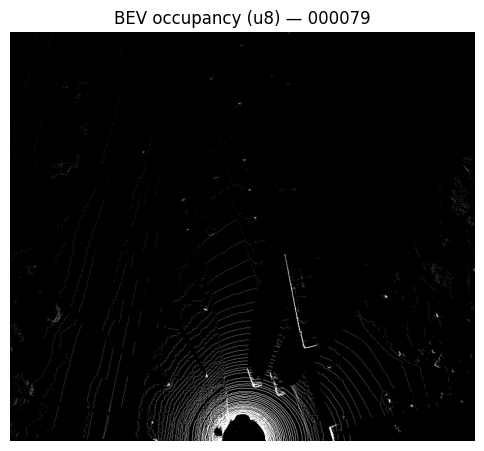

In [18]:
# Cell 5 — visualize one FID BEV u8 (occupancy channel)
FID = ALL_IDS[79]  # pick any available id
bev_u = np.load(RUN_DIR / "bev_u8" / f"{FID}.npy")
plt.figure(figsize=(6,6))
plt.imshow(bev_u[0], origin='lower', cmap='gray')
plt.title(f"BEV occupancy (u8) — {FID}")
plt.axis('off'); plt.show()


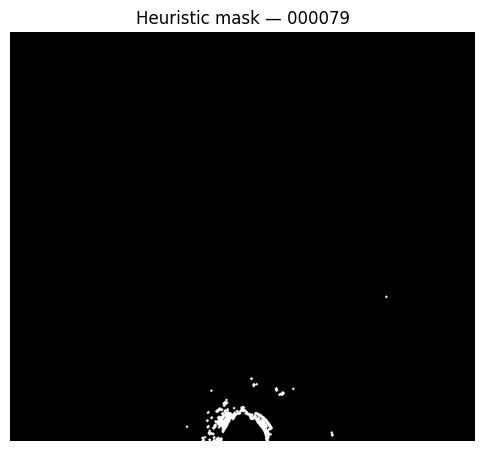

In [19]:
# Cell 6 — heuristic mask from BEV: threshold + cleanup (baseline)
from skimage.morphology import binary_opening

bev_u = np.load(RUN_DIR / "bev_u8" / f"{FID}.npy")
occ = bev_u[0].astype(np.uint8)
mask = (occ >= 30).astype(np.uint8)     # tweak 20–40 as needed
mask = binary_opening(mask, disk(2)).astype(np.uint8)
np.save(RUN_DIR / "masks" / f"{FID}.npy", mask)

plt.figure(figsize=(6,6)); plt.imshow(mask, origin='lower', cmap='gray')
plt.title(f"Heuristic mask — {FID}"); plt.axis('off'); plt.show()


In [31]:
# New utility (place before your builder cell)
import numpy as np

def make_bev_channels_from_points(raw_xyz, cfg, H, W, z_clip=2.0, occ_scale=1.0):
    """
    Inputs:
      raw_xyz: float32 array (N,3) in LiDAR frame (x fwd, y left, z up).
      cfg: must have x_range, y_range, z_range
      H, W: BEV raster size
    Returns:
      X: float32 array (3, H, W) with channels:
         [0] occupancy (0..1), [1] height-above-ground normalized (0..1), [2] log-density (0..1)
    """
    x_range, y_range, z_range = cfg["x_range"], cfg["y_range"], cfg["z_range"]
    x, y, z = raw_xyz.T

    # mask to ROI
    m = (x>=x_range[0])&(x<=x_range[1])&(y>=y_range[0])&(y<=y_range[1])&(z>=z_range[0])&(z<=z_range[1])
    x,y,z = x[m], y[m], z[m]

    # grid indices
    sx = W / (x_range[1]-x_range[0])
    sy = H / (y_range[1]-y_range[0])
    ix = np.floor((x - x_range[0]) * sx).astype(np.int32)
    iy = np.floor((y - y_range[0]) * sy).astype(np.int32)

    # keep in-bounds
    m = (ix>=0)&(ix<W)&(iy>=0)&(iy<H)
    ix, iy, z = ix[m], iy[m], z[m]

    # accumulators
    cnt  = np.zeros((H,W), np.int32)
    zmin = np.full((H,W),  1e6, np.float32)
    zmax = np.full((H,W), -1e6, np.float32)

    np.add.at(cnt, (iy, ix), 1)
    np.minimum.at(zmin, (iy, ix), z)
    np.maximum.at(zmax, (iy, ix), z)

    # column-wise ground estimate (robust 5th percentile of zmin per x-column)
    ground = np.full((W,), np.nan, np.float32)
    for j in range(W):
        col = zmin[:, j]
        mm  = (cnt[:, j] > 0) & np.isfinite(col)
        if mm.any():
            ground[j] = np.percentile(col[mm], 5.0)
    # broadcast to HxW
    ground_map = np.tile(ground, (H,1))

    # height-above-ground
    zmax_filled = np.where(cnt>0, zmax, ground_map)  # avoid NaNs where empty
    hag = np.clip(zmax_filled - ground_map, 0.0, z_clip) / max(z_clip, 1e-6)  # 0..1

    # occupancy (normalize 0..1; optional scaling)
    occ = np.clip(cnt * occ_scale, 0, 255).astype(np.float32) / 255.0

    # log-density (more dynamic range friendly)
    den = np.zeros_like(cnt, np.float32)
    if cnt.max() > 0:
        den = np.log1p(cnt) / np.log1p(cnt.max())

    X = np.stack([occ, hag.astype(np.float32), den.astype(np.float32)], axis=0)
    return X


In [32]:
# Cell 7 — Build a multi-frame dataset (train/val) with 3-channel BEV (occ, HAG, density)
import os, json, random
import numpy as np
from pathlib import Path
from tqdm import tqdm

random.seed(42); np.random.seed(42)

# —— paths (reuse your earlier definitions) ——
# DATA_ROOT must point to the KITTI "training" folder
DATA_ROOT = Path(r"C:\Users\DELL\OpenPCDet\data\kitti\training")  # edit if needed
VELO_DIR  = DATA_ROOT / "velodyne"
CAL_DIR   = DATA_ROOT / "calib"
LAB_DIR   = DATA_ROOT / "label_2"

# outputs
RUN_ROOT  = Path(r"D:\Data\essentials\Thapar\MTech\Projects\Main proj\bev_npu_outputs\new_outputs")
RUN_DIR   = RUN_ROOT / "run_1"
DS_DIR    = RUN_DIR / "dataset_balanced_3ch"
DS_DIR.mkdir(parents=True, exist_ok=True)
for sub in ["train", "val"]:
    (DS_DIR/sub).mkdir(parents=True, exist_ok=True)

# —— config (your ROI & raster) ——
cfg = {
    "x_range": (0.0, 40.0),
    "y_range": (-20.0, 20.0),
    "z_range": (-3.0, 1.0),
    "H": 256, "W": 256
}
KEEP = {"Car", "Van", "Truck", "Cyclist", "Pedestrian"}  # labels we keep

# make sure your golden-mask helpers are already defined (from your previous Cell “fix golden”)
#   golden_mask_for_frame(fid, cfg, keep=KEEP, dilate_px=0)

# choose frames: all, or cap for quick runs
ALL_FIDS = sorted(p.stem for p in VELO_DIR.glob("*.bin"))
MAX_FRAMES = None    # set to e.g. 1200 for quicker build; None = all available
FID_LIST = ALL_FIDS if MAX_FRAMES is None else ALL_FIDS[:MAX_FRAMES]

# split
VAL_FRAC = 0.10
random.shuffle(FID_LIST)
cut = int(len(FID_LIST)*(1.0-VAL_FRAC))
split = {"train": FID_LIST[:cut], "val": FID_LIST[cut:]}

def load_points_bin(fid):
    raw = np.fromfile(VELO_DIR / f"{fid}.bin", dtype=np.float32).reshape(-1,4)
    return raw[:, :3]  # x,y,z

# build
stats = {"train":0, "val":0}
for part, fids in split.items():
    out = DS_DIR / part
    kept = 0
    for fid in tqdm(fids, desc=f"build {part}", unit="frame"):
        xyz = load_points_bin(fid)
        X = make_bev_channels_from_points(xyz, cfg, cfg["H"], cfg["W"], z_clip=2.0, occ_scale=1.0)

        # golden mask from labels
        g = golden_mask_for_frame(fid, cfg, KEEP)  # (H,W) uint8 0/1

        # save one full-size tile per frame: names like 000123_0000_x.npy / _y.npy
        name = f"{fid}_0000"
        np.save(out / f"{name}_x.npy", X.astype(np.float32))
        np.save(out / f"{name}_y.npy", g.astype(np.uint8))
        kept += 1
    stats[part] = kept
print(f"kept tiles: train={stats['train']}  val={stats['val']}")
print(f"in_ch = 3  (occ, HAG, density)")


build train:   0%|                                                                         | 0/6732 [00:00<?, ?frame/s]


TypeError: golden_mask_for_frame() takes 2 positional arguments but 3 were given

In [20]:
# Cell 7_legacy — build balanced tiles (train/val) from multiple frames

import os, json, math, random
from pathlib import Path
import numpy as np
from tqdm import tqdm

tile = 256       # tile size
keep_classes = {"Car","Van","Truck","Cyclist","Pedestrian"}

DS_DIR = RUN_DIR / "dataset_balanced"
(DS_DIR / "train").mkdir(parents=True, exist_ok=True)
(DS_DIR / "val").mkdir(parents=True, exist_ok=True)

# use the BEV that were exported in Cell 4
BEV_IDS = sorted(p.stem for p in (RUN_DIR/"bev_u8").glob("*.npy"))
print("BEV frames available:", len(BEV_IDS))

def save_pair(split_dir, fid, t_id, x, y):
    np.save(split_dir / f"{fid}_{t_id:04d}_x.npy", x.astype(np.float32))
    np.save(split_dir / f"{fid}_{t_id:04d}_y.npy", y.astype(np.float32))

train_frac = 0.9
train_ids = set(BEV_IDS[:int(len(BEV_IDS)*train_frac)])
val_ids   = set(BEV_IDS) - train_ids

def tile_iter(H,W,ts):
    for r in range(0, H, ts):
        for c in range(0, W, ts):
            yield r, c, r+ts, c+ts

pos_kept = {"train":0, "val":0}
neg_kept = {"train":0, "val":0}

for fid in tqdm(BEV_IDS, desc="build tiles"):
    split = "train" if fid in train_ids else "val"
    split_dir = DS_DIR / split
    bev_u = np.load(RUN_DIR / "bev_u8" / f"{fid}.npy")   # (5,H,W)
    H,W = bev_u.shape[1:]
    # channels to use as input (keep first two: occ and zmax)
    x_ch = bev_u[[0,1]]  # (2,H,W)
    # golden mask
    g = golden_mask_for_frame(fid, cfg)                   # (H,W) 0/1
    # tile and save (balance ~1:1 pos:neg)
    t_id = 0
    for r0,c0,r1,c1 in tile_iter(H,W,tile):
        x = x_ch[:, r0:r1, c0:c1]
        y = g[r0:r1, c0:c1][None, ...]
        if x.shape[1]!=tile or x.shape[2]!=tile: continue
        pos = (y.sum() > 0)
        if pos:
            save_pair(split_dir, fid, t_id, x, y); pos_kept[split]+=1; t_id+=1
        else:
            # keep 1 out of N negatives to balance — here N=40
            if random.random() < 1/40:
                save_pair(split_dir, fid, t_id, x, y); neg_kept[split]+=1; t_id+=1

print("kept (train): pos", pos_kept["train"], "neg", neg_kept["train"])
print("kept (val)  : pos", pos_kept["val"],   "neg", neg_kept["val"])


BEV frames available: 500


build tiles: 100%|███████████████████████████████████████████████████████████████████| 500/500 [02:15<00:00,  3.68it/s]

kept (train): pos 952 neg 34
kept (val)  : pos 106 neg 3


In [21]:
# Cell 7a — quick stats: how imbalanced are tiles?

def sample_frac_pos(split):
    xs = sorted((DS_DIR/split).glob("*_x.npy"))
    ys = sorted((DS_DIR/split).glob("*_y.npy"))
    if not xs: 
        print(f"{split}: no tiles"); return 0.0
    n = min(len(xs), 500)   # sample up to 500 tiles
    sel = random.sample(range(len(xs)), n)
    pos = 0
    for i in sel:
        y = np.load(ys[i])
        if y.sum()>0: pos += 1
    frac = pos/n
    print(f"{split}: tiles={len(xs)}  sample_pos%={frac*100:.3f}%")
    return frac

frac_train = sample_frac_pos("train")
frac_val   = sample_frac_pos("val")


train: tiles=986  sample_pos%=96.800%
val: tiles=109  sample_pos%=97.248%


In [22]:
# Cell 7b — recommend POS_WEIGHT for BCEWithLogitsLoss

def recommend_pos_weight(frac_pos):
    # if only ~1% tiles have positives, a weight ~ (1/fr) works as a starting point
    if frac_pos <= 0: return 1.0
    return max(1.0, round(1.0/frac_pos, 1))

pw = recommend_pos_weight(frac_train if frac_train>0 else 0.01)
print(f"Suggested POS_WEIGHT ≈ {pw} (based on train sample pos%={frac_train*100:.3f}%)")


Suggested POS_WEIGHT ≈ 1.0 (based on train sample pos%=96.800%)


In [26]:
# Cell 7c — compute pos_rate and POS_WEIGHT from the dataset
from pathlib import Path
import numpy as np

def compute_pos_rate(ds_root: Path):
    ds_root = Path(ds_root)
    total = 0
    pos   = 0
    for split in ["train", "val"]:
        for yfile in (ds_root/split).glob("*_y.npy"):
            y = np.load(yfile)
            y = np.squeeze(y).astype(bool)   # (H,W)
            total += y.size
            pos   += int(y.sum())
    rate = pos / max(1, total)
    return rate

pos_rate = compute_pos_rate(DS_DIR)
POS_WEIGHT = float((1.0 - pos_rate) / max(1e-6, pos_rate))
print(f"pos_rate={pos_rate:.4%}  ->  POS_WEIGHT={POS_WEIGHT:.2f}")


pos_rate=2.5945%  ->  POS_WEIGHT=37.54


In [25]:
# SHAPE_PROBE — inspect a few tiles on disk
from pathlib import Path
import numpy as np

def probe(root):
    root = Path(root)
    xs = sorted(root.glob("*_x.npy"))
    ys = [x.with_name(x.name.replace("_x.npy","_y.npy")) for x in xs]
    for i,(x,y) in enumerate(zip(xs,ys)):
        X = np.load(x); Y = np.load(y)
        print(i, x.name, X.shape, "|", y.name, Y.shape)
        if i==4: break

print("train:")
probe(DS_DIR/"train")
print("\nval:")
probe(DS_DIR/"val")


train:
0 000000_0000_x.npy (2, 256, 256) | 000000_0000_y.npy (1, 256, 256)
1 000001_0000_x.npy (2, 256, 256) | 000001_0000_y.npy (1, 256, 256)
2 000002_0000_x.npy (2, 256, 256) | 000002_0000_y.npy (1, 256, 256)
3 000003_0000_x.npy (2, 256, 256) | 000003_0000_y.npy (1, 256, 256)
4 000003_0001_x.npy (2, 256, 256) | 000003_0001_y.npy (1, 256, 256)

val:
0 000450_0000_x.npy (2, 256, 256) | 000450_0000_y.npy (1, 256, 256)
1 000450_0001_x.npy (2, 256, 256) | 000450_0001_y.npy (1, 256, 256)
2 000451_0000_x.npy (2, 256, 256) | 000451_0000_y.npy (1, 256, 256)
3 000452_0000_x.npy (2, 256, 256) | 000452_0000_y.npy (1, 256, 256)
4 000452_0001_x.npy (2, 256, 256) | 000452_0001_y.npy (1, 256, 256)


In [28]:
# Improved Cell 8 — Train (BCE+Dice, LR schedule, threshold sweep)

import torch, torch.nn as nn, torch.nn.functional as F
import numpy as np

# ---- knobs ----
EPOCHS     = 30
LR         = 1e-3
THR_SWEEP  = [0.30, 0.40, 0.50]   # evaluate IoU at these thresholds
device     = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# If POS_WEIGHT wasn’t defined, fall back to 5.0
try:    POS_WEIGHT
except: POS_WEIGHT = 5.0
print("Using POS_WEIGHT =", POS_WEIGHT)

# --- soft Dice ---
def soft_dice_loss(logits, targets, eps=1e-6):
    probs  = torch.sigmoid(logits)
    inter  = (probs*targets).sum(dim=(1,2,3))
    denom  = probs.sum(dim=(1,2,3)) + targets.sum(dim=(1,2,3))
    dice   = (2*inter + eps)/(denom + eps)
    return 1 - dice.mean()

# --- IoU with configurable threshold ---
def iou_logits_thr(logits, target, thr=0.5, eps=1e-6):
    p = (torch.sigmoid(logits)>thr).float()
    inter = (p*target).sum()
    union = p.sum() + target.sum() - inter
    return ((inter+eps)/(union+eps)).item()

model = TinyBEV(IN_CH).to(device)
opt   = torch.optim.Adam(model.parameters(), lr=LR)
bce   = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([POS_WEIGHT], device=device))
sched = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='max', factor=0.5, patience=3, verbose=True)

print(f"tiles: train={len(train_loader.dataset)}  val={len(val_loader.dataset)}  in_ch={IN_CH}  pos_w={POS_WEIGHT:.2f}")
best = 0.0

for ep in range(1, EPOCHS+1):
    # ---- train ----
    model.train(); tot=0; n=0
    for xb,yb in train_loader:
        xb,yb = xb.to(device), yb.to(device)
        logits = model(xb)
        loss = bce(logits, yb) + 0.5*soft_dice_loss(logits, yb)   # BCE + 0.5*Dice
        opt.zero_grad(); loss.backward(); opt.step()
        tot += loss.item()*xb.size(0); n += xb.size(0)

    # ---- validate (IoU at multiple thresholds) ----
    model.eval()
    iou_by_thr = {thr: [] for thr in THR_SWEEP}
    with torch.no_grad():
        for xb,yb in val_loader:
            xb,yb = xb.to(device), yb.to(device)
            logits = model(xb)
            for thr in THR_SWEEP:
                iou_by_thr[thr].append(iou_logits_thr(logits, yb, thr=thr))
    val_iou = {thr: float(np.mean(v)) if len(v) else 0.0 for thr, v in iou_by_thr.items()}
    # choose the middle threshold as scheduler metric
    metric_thr = THR_SWEEP[1]
    sched.step(val_iou[metric_thr])

    msg = " ".join([f"t{thr:.2f}:{val_iou[thr]:.3f}" for thr in THR_SWEEP])
    print(f"epoch {ep:02d} | train_loss {tot/max(1,n):.4f} | val IoU {msg}")

    if val_iou[metric_thr] > best:
        best = val_iou[metric_thr]
        torch.save(model.state_dict(), RUN_DIR/"tiny_bev.pt")

print("saved model to:", RUN_DIR/"tiny_bev.pt")


Using POS_WEIGHT = 37.54278236424855
tiles: train=986  val=109  in_ch=2  pos_w=37.54


C:\Users\DELL\anaconda3\envs\pointpillars\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


epoch 01 | train_loss 1.7706 | val IoU t0.30:0.023 t0.40:0.024 t0.50:0.048
epoch 02 | train_loss 1.6972 | val IoU t0.30:0.024 t0.40:0.041 t0.50:0.049
epoch 03 | train_loss 1.6465 | val IoU t0.30:0.025 t0.40:0.046 t0.50:0.052
epoch 04 | train_loss 1.6102 | val IoU t0.30:0.025 t0.40:0.050 t0.50:0.060
epoch 05 | train_loss 1.5856 | val IoU t0.30:0.026 t0.40:0.054 t0.50:0.068
epoch 06 | train_loss 1.5796 | val IoU t0.30:0.026 t0.40:0.052 t0.50:0.062
epoch 07 | train_loss 1.5609 | val IoU t0.30:0.027 t0.40:0.061 t0.50:0.084
epoch 08 | train_loss 1.5471 | val IoU t0.30:0.044 t0.40:0.052 t0.50:0.063
epoch 09 | train_loss 1.5423 | val IoU t0.30:0.047 t0.40:0.057 t0.50:0.068
epoch 10 | train_loss 1.5311 | val IoU t0.30:0.027 t0.40:0.061 t0.50:0.072
epoch 11 | train_loss 1.5179 | val IoU t0.30:0.028 t0.40:0.063 t0.50:0.079
epoch 12 | train_loss 1.5229 | val IoU t0.30:0.027 t0.40:0.059 t0.50:0.070
epoch 13 | train_loss 1.5187 | val IoU t0.30:0.028 t0.40:0.062 t0.50:0.076
epoch 14 | train_loss 1.5

In [29]:
# Cell 8b — pick best threshold on val set for your saved model
import torch, numpy as np
from pathlib import Path

thr_grid = np.linspace(0.2, 0.8, 25)  # finer sweep
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

m = TinyBEV(IN_CH).to(device)
m.load_state_dict(torch.load(RUN_DIR/"tiny_bev.pt", map_location=device))
m.eval()

def iou_logits_thr(logits, target, thr=0.5, eps=1e-6):
    p = (torch.sigmoid(logits)>thr).float()
    inter = (p*target).sum()
    union = p.sum() + target.sum() - inter
    return ((inter+eps)/(union+eps)).item()

ious = []
with torch.no_grad():
    for thr in thr_grid:
        per = []
        for xb,yb in val_loader:
            xb,yb = xb.to(device), yb.to(device)
            per.append(iou_logits_thr(m(xb), yb, thr=float(thr)))
        ious.append(np.mean(per) if per else 0.0)

best_thr = float(thr_grid[int(np.argmax(ious))])
best_iou = float(max(ious))
print(f"Best val IoU {best_iou:.3f} @ threshold {best_thr:.2f}")


C:\Users\DELL\AppData\Local\Temp\ipykernel_11584\1675937702.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m.load_state_dict(torch.load(RUN_DIR/"tiny_bev.pt", map_locat

Best val IoU 0.198 @ threshold 0.80


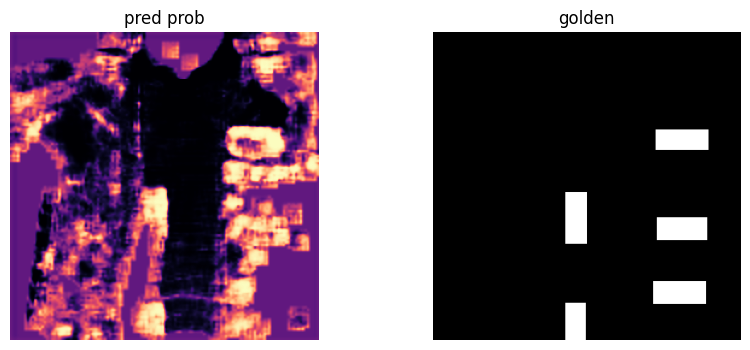

In [30]:
# Cell 8c — quick visualization
import matplotlib.pyplot as plt, random, torch, numpy as np
m.eval()
xb,yb = next(iter(val_loader))
i = random.randrange(xb.size(0))
with torch.no_grad():
    pr = torch.sigmoid(m(xb.to(device)))[i,0].cpu().numpy()
gt = yb[i,0].numpy()
plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.imshow(pr, cmap='magma'); plt.title("pred prob"); plt.axis('off')
plt.subplot(1,2,2); plt.imshow(gt, cmap='gray');  plt.title("golden");    plt.axis('off')
plt.show()
